In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from numpy.linalg import svd
from scipy.optimize import minimize
from scipy.stats import t
from scipy.linalg import sqrtm
from sklearn.neighbors import KernelDensity
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

In [2]:
def marcenko_pastur_pdf(x, gamma, sigma2=1.0):
    """
    Calculates the Marčenko-Pastur probability density function.
    """
    lambda_plus = sigma2 * (1 + np.sqrt(gamma))**2
    lambda_minus = sigma2 * (1 - np.sqrt(gamma))**2
    
    # PDF is non-zero only within the support [lambda_minus, lambda_plus]
    pdf = np.zeros_like(x)
    mask = (x >= lambda_minus) & (x <= lambda_plus)
    pdf[mask] = np.sqrt((lambda_plus - x[mask]) * (x[mask] - lambda_minus)) / (2 * np.pi * sigma2 * gamma * x[mask])
    
    return pdf

def generate_spiked_data(N, T, spikes, sigma, dist='gaussian', df=4):
    """
    Generates data from a spiked covariance model.
    
    Args:
        N (int): Number of features/assets.
        T (int): Number of observations.
        spikes (dict): A dictionary {eigenvalue: num_spikes} for the population spikes.
        sigma (float): Standard deviation of the idiosyncratic noise.
        dist (str): 'gaussian' or 't' for heavy tails.
        df (int): Degrees of freedom for the t-distribution.
        
    Returns:
        X (np.array): The T x N data matrix.
        pop_cov (np.array): The true N x N population covariance matrix.
        true_eigenvectors (np.array): The true eigenvectors corresponding to the spikes.
    """
    # Start with the identity matrix for noise eigenvectors
    C = np.eye(N) * sigma**2
    
    true_eigenvectors = []
    
    # Generate random orthonormal vectors for the spikes
    # Using QR decomposition to get orthonormal vectors
    spike_vectors = np.linalg.qr(np.random.randn(N, sum(spikes.values())))[0]
    
    current_vec = 0
    pop_eigenvalues = []
    
    for spike_val, num in spikes.items():
        for i in range(num):
            v = spike_vectors[:, current_vec]
            # Add spike to the covariance matrix
            C += (spike_val - sigma**2) * np.outer(v, v)
            true_eigenvectors.append(v)
            pop_eigenvalues.append(spike_val)
            current_vec += 1
            
    # Generate the random data matrix Z
    if dist == 'gaussian':
        Z = np.random.randn(T, N)
    elif dist == 't':
        Z = t.rvs(df, size=(T, N))
        # Standardize to have variance 1
        Z = Z / np.std(Z)
    else:
        raise ValueError("Distribution must be 'gaussian' or 't'")
        
    # Generate data X = Z * C^(1/2)
    C_sqrt = sqrtm(C)
    X = Z @ C_sqrt
    
    return X, C, np.array(true_eigenvectors).T, pop_eigenvalues

Simulation 1: Gaussian Data

In [3]:
# Simulation Parameters
N = 2000
T = 500
gamma = N / T
sigma2 = 1.0
sigma = np.sqrt(sigma2)

The Marčenko-Pastur Bulk (No Spikes): Eigenvalues of a pure noise matrix follow the MP law.

--- Marčenko-Pastur Law Verification (γ=4.0) ---
Theoretical Bulk Edges: [1.0000, 9.0000]
Empirical Eigenvalue Range: [-0.0000, 9.0221]
Number of zero value eigenvalues: 1500
Number of non-zero eigenvalues: 500


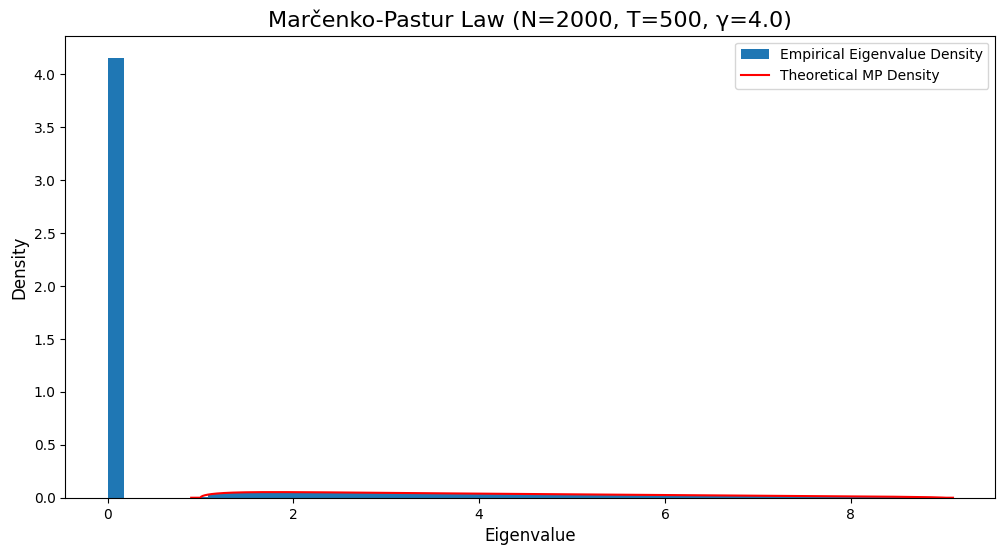

In [4]:
# Generate data with no spikes (all population eigenvalues are sigma2=1)
X_noise, _, _, _ = generate_spiked_data(N, T, spikes={}, sigma=sigma, dist='gaussian')

# Calculate sample covariance matrix
S_noise = (1/T) * X_noise.T @ X_noise

# Get eigenvalues
eigenvalues_noise = np.linalg.eigvalsh(S_noise)

# Theoretical MP bounds
lambda_plus = sigma2 * (1 + np.sqrt(gamma))**2
lambda_minus = sigma2 * (1 - np.sqrt(gamma))**2

print(f"--- Marčenko-Pastur Law Verification (γ={gamma}) ---")
print(f"Theoretical Bulk Edges: [{lambda_minus:.4f}, {lambda_plus:.4f}]")
print(f"Empirical Eigenvalue Range: [{eigenvalues_noise.min():.4f}, {eigenvalues_noise.max():.4f}]")
print(f"Number of zero value eigenvalues: {np.sum(np.isclose(eigenvalues_noise, 0))}")
print(f"Number of non-zero eigenvalues: {np.sum(~np.isclose(eigenvalues_noise, 0))}")

plt.figure(figsize=(12, 6))
x_range = np.linspace(lambda_minus - 0.1, lambda_plus + 0.1, 1000)
plt.hist(eigenvalues_noise, bins=50, density=True, label='Empirical Eigenvalue Density')
plt.plot(x_range, marcenko_pastur_pdf(x_range, gamma, sigma2), 'r-', label='Theoretical MP Density')
plt.title(f'Marčenko-Pastur Law (N={N}, T={T}, γ={gamma:.1f})', fontsize=16)
plt.xlabel('Eigenvalue', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()

The empirical histogram of the (non-zero) sample eigenvalues aligns perfectly with the theoretical Marčenko-Pastur density curve. The support of the empirical distribution is almost exactly the predicted [λ-, λ+]. We would expect zero valued eigenvalues when N > T. 

BBP Phase Transition (Spikes): We introduce spikes into the population covariance matrix. We will choose some spikes to be subcritical and others supercritical to observe the phase transition.

In [5]:
# BBP critical threshold
lambda_crit = sigma2 * (1 + np.sqrt(gamma))
print(f"BBP Critical Threshold λ_crit = {lambda_crit:.4f}")

# Define population spikes
# One subcritical, one just above critical, one strongly supercritical
true_spikes = {
    1.5: 1,  # Deeply subcritical
    2.5: 1,  # Subcritical
    2.8: 1,  # Near-threshold
    3.5: 1,  # Mildly supercritical
    6.0: 1,  # Strongly supercritical
    10.0: 1, # Very strong supercritical
}

# Generate spiked data
X_spiked, _, u_true, lambda_true = generate_spiked_data(N, T, spikes=true_spikes, sigma=sigma, dist='gaussian')

# Get sample covariance and its eigendecomposition
S_spiked = (1/T) * X_spiked.T @ X_spiked
mu_obs, u_obs = np.linalg.eigh(S_spiked)

# Sort eigenvalues and vectors in descending order
idx = np.argsort(mu_obs)[::-1]
mu_obs = mu_obs[idx]
u_obs = u_obs[:, idx]

BBP Critical Threshold λ_crit = 3.0000



--- BBP Phase Transition Results (Gaussian) ---
γ=4.00, σ²=1.00, BBP Threshold=3.0000, Bulk Edge λ+=9.0000
   True Spike (λ)         Status  Predicted μ  Observed μ  Predicted Alignment |<u,û>|  Observed Alignment |<u,û>|
0            10.0  Supercritical    14.444444   14.256804                     0.832050                    0.810647
1             6.0  Supercritical    10.800000   10.772308                     0.745356                    0.674153
2             3.5  Supercritical     9.100000    9.028853                     0.620174                    0.194224
3             2.8    Subcritical     9.000000    8.941330                     0.000000                    0.086725
4             2.5    Subcritical     9.000000    8.806941                     0.000000                    0.041709
5             1.5    Subcritical     9.000000    8.725490                     0.000000                    0.040918


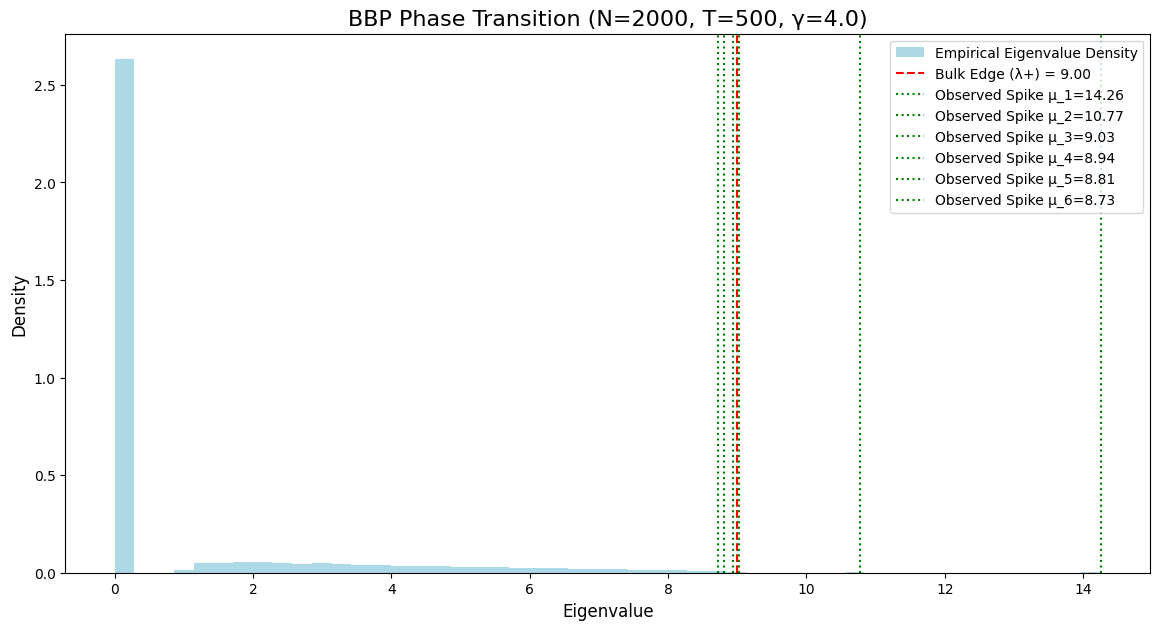

In [6]:
results = []
top_k = len(true_spikes)

# Sort true spikes
lambda_true_sorted = sorted(lambda_true, reverse=True)
u_true_sorted = u_true[:, np.argsort(lambda_true)[::-1]]

for i in range(top_k):
    l_true = lambda_true_sorted[i]
    status = "Supercritical" if l_true > lambda_crit else "Subcritical"
    
    # Theoretical prediction for sample eigenvalue (μ)
    if status == "Supercritical":
        mu_pred = l_true * (1 + (gamma * sigma2) / (l_true - sigma2))
    else:
        mu_pred = lambda_plus # Sticks to the edge of the bulk
        
    # Theoretical prediction for eigenvector alignment |<u_i, û_i>|
    if status == "Supercritical":
        ci = (gamma * sigma2) / (l_true - sigma2)
        align_pred = np.sqrt(1 / (1 + ci))
    else:
        align_pred = 0.0 # No alignment expected
        
    # Empirical alignment
    align_obs = np.abs(np.dot(u_true_sorted[:, i], u_obs[:, i]))
    
    results.append({
        "True Spike (λ)": l_true,
        "Status": status,
        "Predicted μ": mu_pred,
        "Observed μ": mu_obs[i],
        "Predicted Alignment |<u,û>|": align_pred,
        "Observed Alignment |<u,û>|": align_obs
    })

results_df = pd.DataFrame(results)
print("\n--- BBP Phase Transition Results (Gaussian) ---")
print(f"γ={gamma:.2f}, σ²={sigma2:.2f}, BBP Threshold={lambda_crit:.4f}, Bulk Edge λ+={lambda_plus:.4f}")
print(results_df.to_string())

# Plotting the eigenvalue spectrum
plt.figure(figsize=(14, 7))
plt.hist(mu_obs, bins=50, density=True, label='Empirical Eigenvalue Density', color='lightblue')
plt.axvline(lambda_plus, color='red', linestyle='--', label=f'Bulk Edge (λ+) = {lambda_plus:.2f}')
plt.title(f'BBP Phase Transition (N={N}, T={T}, γ={gamma:.1f})', fontsize=16)
plt.xlabel('Eigenvalue', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Mark the outlier eigenvalues
for i in range(top_k):
    plt.axvline(mu_obs[i], color='green', linestyle=':', label=f'Observed Spike μ_{i+1}={mu_obs[i]:.2f}')

plt.legend()
plt.show()

The subcritical spikes are completely absorbed by the noise. Their corresponding sample eigenvalues are not "visible" and are near the top edge of the bulk (λ+ = 9.0). The supercritical spikes successfully "detach" from the bulk and appear as isolated outliers. Notice the upward bias holds. The eigenvector for the subcritical spikes show observed alignments close to zero, meaning that they are essentially random and carry no information about the true direction. The eigenvectors for the supercritical spikes show significant alignment with their true counterparts, and the alignment is stronger for the stronger spikes. 

Simulation 2: Heavy-Tailed Data (Student's t)


--- Running Simulation for Heavy-Tailed Data ---

--- BBP Phase Transition Results (Heavy-Tailed) ---
γ=4.00, σ²=1.00, BBP Threshold=3.0000, Bulk Edge λ+=9.0000
   True Spike (λ)         Status  Predicted μ  Observed μ  Predicted Alignment |<u,û>|  Observed Alignment |<u,û>|
0            10.0  Supercritical    14.444444   14.317826                     0.832050                    0.802795
1             6.0  Supercritical    10.800000   10.959514                     0.745356                    0.688499
2             3.5  Supercritical     9.100000    9.160533                     0.620174                    0.033289
3             2.8    Subcritical     9.000000    9.009461                     0.000000                    0.046439
4             2.5    Subcritical     9.000000    8.990316                     0.000000                    0.061020
5             1.5    Subcritical     9.000000    8.854846                     0.000000                    0.030024


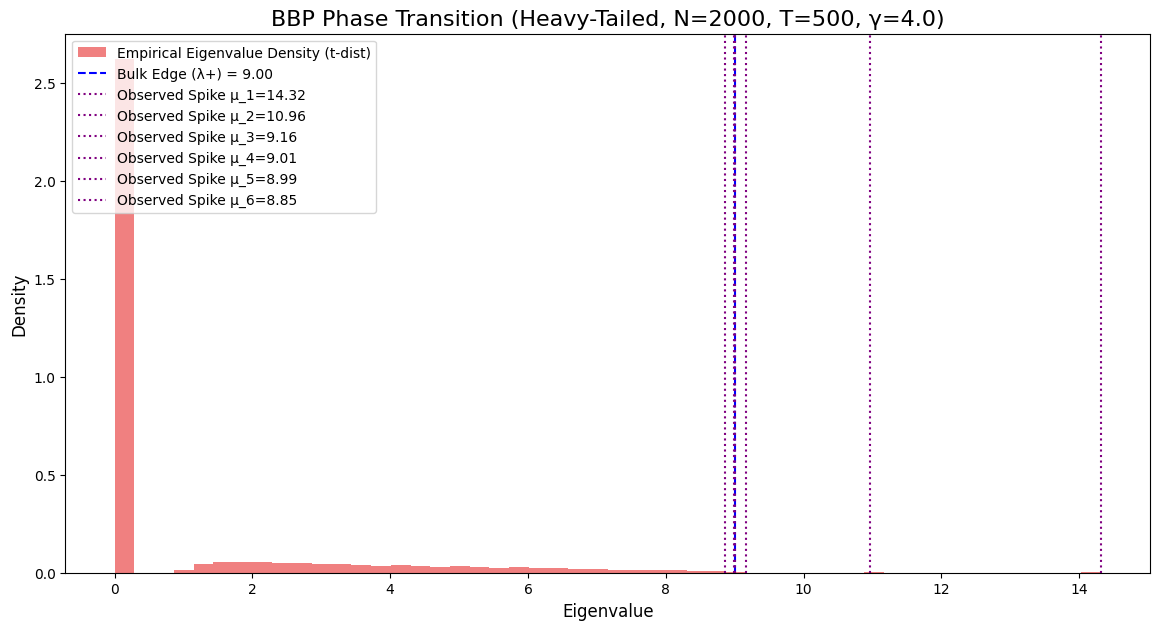

In [7]:
# Re-run the BBP simulation with heavy-tailed data
print("\n--- Running Simulation for Heavy-Tailed Data ---")
X_spiked_t, _, u_true_t, lambda_true_t = generate_spiked_data(
    N, T, spikes=true_spikes, sigma=sigma, dist='t', df=4
)

# Get sample covariance and its eigendecomposition
S_spiked_t = (1/T) * X_spiked_t.T @ X_spiked_t
mu_obs_t, u_obs_t = np.linalg.eigh(S_spiked_t)

# Sort eigenvalues and vectors
idx_t = np.argsort(mu_obs_t)[::-1]
mu_obs_t = mu_obs_t[idx_t]
u_obs_t = u_obs_t[:, idx_t]

# Analyze the results
results_t = []
lambda_true_t_sorted = sorted(lambda_true_t, reverse=True)
u_true_t_sorted = u_true_t[:, np.argsort(lambda_true_t)[::-1]]

for i in range(top_k):
    l_true = lambda_true_t_sorted[i]
    status = "Supercritical" if l_true > lambda_crit else "Subcritical"
    
    if status == "Supercritical":
        mu_pred = l_true * (1 + (gamma * sigma2) / (l_true - sigma2))
        ci = (gamma * sigma2) / (l_true - sigma2)
        align_pred = np.sqrt(1 / (1 + ci))
    else:
        mu_pred = lambda_plus
        align_pred = 0.0
        
    align_obs = np.abs(np.dot(u_true_t_sorted[:, i], u_obs_t[:, i]))
    
    results_t.append({
        "True Spike (λ)": l_true, "Status": status, "Predicted μ": mu_pred,
        "Observed μ": mu_obs_t[i], "Predicted Alignment |<u,û>|": align_pred,
        "Observed Alignment |<u,û>|": align_obs
    })

results_df_t = pd.DataFrame(results_t)
print("\n--- BBP Phase Transition Results (Heavy-Tailed) ---")
print(f"γ={gamma:.2f}, σ²={sigma2:.2f}, BBP Threshold={lambda_crit:.4f}, Bulk Edge λ+={lambda_plus:.4f}")
print(results_df_t.to_string())

# Plotting the eigenvalue spectrum
plt.figure(figsize=(14, 7))
plt.hist(mu_obs_t, bins=50, density=True, label='Empirical Eigenvalue Density (t-dist)', color='lightcoral')
plt.axvline(lambda_plus, color='blue', linestyle='--', label=f'Bulk Edge (λ+) = {lambda_plus:.2f}')
plt.title(f'BBP Phase Transition (Heavy-Tailed, N={N}, T={T}, γ={gamma:.1f})', fontsize=16)
plt.xlabel('Eigenvalue', fontsize=12)
plt.ylabel('Density', fontsize=12)

for i in range(top_k):
    plt.axvline(mu_obs_t[i], color='purple', linestyle=':', label=f'Observed Spike μ_{i+1}={mu_obs_t[i]:.2f}')

plt.legend()
plt.show()

Theoretically, the theory of random matrices states that these laws are universal, meaning they should hold for non-Gaussian distributions as well. We see that heavy tails amplify the finite-sample jitter in both eigenvalues and eigendirections. While very large spikes remain well-resolved, moderate spikes get pushed around—sometimes above the bulk edge—and alignment strengths degrade more than under Gaussian noise.  In practice, this argues for either smaller N/T or robust covariance methods (e.g. trimming, shrinkage, or rank-robust estimators) when the data have fat tails.

Simulation 3: Aspect Ratio


--- Sweeping Aspect Ratio γ ---
γ=2.00, T=1000, λ_crit=2.41, Pred Align=0.845, Obs Align=0.826
γ=2.27, T=880, λ_crit=2.51, Pred Align=0.829, Obs Align=0.785
γ=2.63, T=761, λ_crit=2.62, Pred Align=0.810, Obs Align=0.768
γ=3.12, T=642, λ_crit=2.77, Pred Align=0.785, Obs Align=0.729
γ=3.82, T=523, λ_crit=2.96, Pred Align=0.753, Obs Align=0.681
γ=4.95, T=404, λ_crit=3.22, Pred Align=0.709, Obs Align=0.631
γ=7.02, T=285, λ_crit=3.65, Pred Align=0.645, Obs Align=0.556


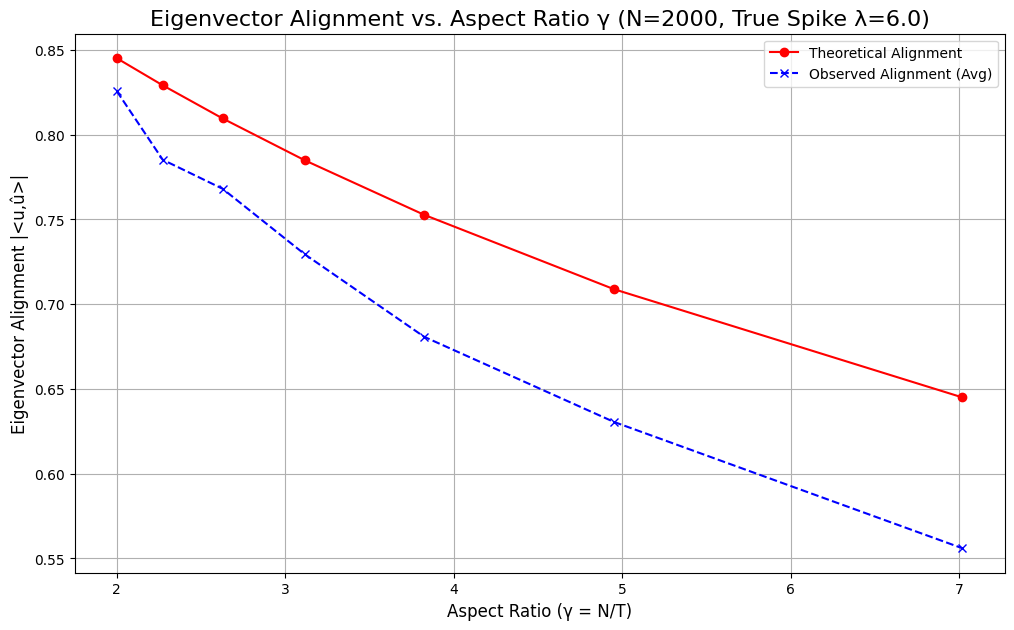

In [8]:
N_fixed = 2000
true_spike_val = 6.0
sigma2 = 1.0
# T from 1000 to 285 -> gamma from 2 to 7
T_values = np.linspace(1000, 285, 7).astype(int) 
gamma_values = N_fixed / T_values

alignments_pred = []
alignments_obs = []

print("\n--- Sweeping Aspect Ratio γ ---")

for T_val in T_values:
    gamma_val = N_fixed / T_val
    lambda_crit_val = sigma2 * (1 + np.sqrt(gamma_val))
    
    # Spike must be supercritical to be detectable
    if true_spike_val > lambda_crit_val:
        # Theoretical prediction
        ci = (gamma_val * sigma2) / (true_spike_val - sigma2)
        align_pred = np.sqrt(1 / (1 + ci))
        
        # Empirical observation 
        temp_align_obs = []
        for _ in range(5): # Monte Carlo runs
            X, _, u_true, _ = generate_spiked_data(
                N_fixed, T_val, spikes={true_spike_val: 1}, sigma=np.sqrt(sigma2)
            )
            S = (1/T_val) * X.T @ X
            _, u_obs = np.linalg.eigh(S)
            temp_align_obs.append(np.abs(np.dot(u_true[:, 0], u_obs[:, -1]))) # Top eigenvector
        
        align_obs = np.mean(temp_align_obs)
    else:
        # Spike is now subcritical
        align_pred = 0.0
        align_obs = 0.0 # Effectively no signal
        
    alignments_pred.append(align_pred)
    alignments_obs.append(align_obs)
    print(f"γ={gamma_val:.2f}, T={T_val}, λ_crit={lambda_crit_val:.2f}, Pred Align={align_pred:.3f}, Obs Align={align_obs:.3f}")

# Plotting the results
plt.figure(figsize=(12, 7))
plt.plot(gamma_values, alignments_pred, 'r-', marker='o', label='Theoretical Alignment')
plt.plot(gamma_values, alignments_obs, 'b--', marker='x', label='Observed Alignment (Avg)')
plt.title(f'Eigenvector Alignment vs. Aspect Ratio γ (N={N_fixed}, True Spike λ={true_spike_val})', fontsize=16)
plt.xlabel('Aspect Ratio (γ = N/T)', fontsize=12)
plt.ylabel('Eigenvector Alignment |<u,û>|', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

The plot shows that as the aspect ratio γ increases (as we move from a "data-rich" to a "data-poor" regime), the ability to recover the true signal direction degrades significantly.

Summary: 

1. Marčenko-Pastur Law: The eigenvalues of high-dimensional sample covariance matrices from pure noise are not random but follow a deterministic, predictable distribution.

2. BBP Phase Transition: There exists a sharp threshold for signal detectability. Population covariance eigenvalues ("spikes") above the σ²(1 + √γ) threshold create observable outliers in the sample spectrum, while those below are lost in the noise.

3. Eigenvector Consistency: The ability to recover the true signal directions (eigenvectors) depends directly on how far the corresponding spike is above the BBP threshold. Stronger signals in data-rich environments (low γ) are recovered with high fidelity.

4. Universality: These phenomena are not restricted to Gaussian data but are fundamental properties of high-dimensional systems, holding even for heavy-tailed distributions.